## Librerías y funciones

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install pandas openpyxl

import pandas as pd
import pandas as pd
import re
import numpy as np

In [9]:
def limpiar_columnas_principalmente_numericas(df, threshold=0.8):
    """
    Identifica y limpia columnas que son principalmente numéricas, considerando espacios en blanco.

    Parameters:
    - df: DataFrame en pandas.
    - threshold: Proporción mínima de valores numéricos en la columna para considerarla "principalmente numérica".

    Returns:
    - DataFrame con las columnas numéricas limpiadas.
    - Lista de columnas que fueron transformadas.
    """
    columnas_numericas_limpias = []

    for columna in df.columns:
        # Contamos valores que contienen solo números, comas, puntos o espacios
        valid_numeric_count = df[columna].astype(str).apply(lambda x: bool(re.match(r'^[0-9.,\s]*$', x))).sum()
        total_count = df[columna].notna().sum()

        # Verifica si la columna es "principalmente numérica" usando el umbral especificado
        if total_count > 0 and (valid_numeric_count / total_count) >= threshold:
            # Agrega a la lista de columnas principalmente numéricas
            columnas_numericas_limpias.append(columna)

            # Limpia valores dejando solo números, comas y puntos (removemos espacios en blanco)
            df[columna] = df[columna].astype(str).apply(lambda x: re.sub(r'[^0-9.,]', '', x))

            # Convierte la columna a numérica, asignando NaN a los valores no convertibles
            df[columna] = pd.to_numeric(df[columna], errors='coerce')

    return df, columnas_numericas_limpias

In [10]:
def eliminar_espacios_columnas(df):
    # Eliminar espacios en los nombres de las columnas
    df.columns = df.columns.str.replace(' ', '', regex=False)
    return df

## Carga de datos

In [11]:
# Ruta al archivo Excel
file_path = '/content/drive/MyDrive/Proyectos de datos/Prueba_tecnica/Films_2.xlsx'

# Leer el archivo Excel
excel_file = pd.ExcelFile(file_path)

# Obtener el nombre de todas las hojas (páginas)
sheet_names = excel_file.sheet_names
print("Hojas disponibles:", sheet_names)

Hojas disponibles: ['MER', 'film', 'inventory', 'rental', 'customer', 'store']


In [12]:
df_film = pd.read_excel(file_path, sheet_name=1)
df_inventory = pd.read_excel(file_path, sheet_name=2)
df_rental = pd.read_excel(file_path, sheet_name=3)
df_customer = pd.read_excel(file_path, sheet_name=4)
df_store = pd.read_excel(file_path, sheet_name=5)

## Análisis exploratorio

In [13]:
print("Dimensiones Store:", df_store.shape)
print("Dimensiones Customer:", df_customer.shape)
print("Dimensiones Rental:", df_rental.shape)
print("Dimensiones Inventory:", df_inventory.shape)
print("Dimensiones Film:", df_film.shape)

Dimensiones Store: (2, 4)
Dimensiones Customer: (1392, 11)
Dimensiones Rental: (16044, 7)
Dimensiones Inventory: (4581, 4)
Dimensiones Film: (1003, 14)


In [ ]:
print(df_rental.info())
print(df_inventory.info())
print(df_film.info())
print(df_store.info())
print(df_customer.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rental_id      16044 non-null  int64 
 1    rental_date   16044 non-null  object
 2    inventory_id  16044 non-null  int64 
 3    customer_id   16044 non-null  int64 
 4    return_date   16044 non-null  object
 5    staff_id      16044 non-null  int64 
 6    last_update   16044 non-null  object
dtypes: int64(4), object(3)
memory usage: 877.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   inventory_id  4581 non-null   int64 
 1   film_id       4581 non-null   int64 
 2    store_id     4581 non-null   object
 3    last_update  4581 non-null   object
dtypes: int64(2), object(2)
memory usage: 143.3+ KB
None
<class 'pandas.core.frame.DataFra

Se puede observar como los nombres de las columnas tienen espacios en blanque que dificultan el tratamiento de la informacion, por lo que es necesario eliminarlas,

Adicionalmente es necesario verificar el formato de las columnas, dado que segun el diagrama MER el tipo de datos esta errado.

Es necesario eliminar comvertir los valores nulos.

### Limpieza de datos

In [14]:
dataframes = [df_store, df_customer, df_rental, df_inventory, df_film]
for i, df in enumerate(dataframes):
    df_limpio = eliminar_espacios_columnas(df)
    df_limpio, columnas_identificadas = limpiar_columnas_principalmente_numericas(df_limpio)
    df.replace(r'^\s*(NULL|N/A)?\s*$', np.nan, regex=True, inplace=True)
    df = df.drop_duplicates()
    #print(f"DataFrame limpio {i+1}:\n", df)
    print(f"Columnas principalmente numéricas que fueron transformadas en DataFrame {i+1}:\n", columnas_identificadas)

Columnas principalmente numéricas que fueron transformadas en DataFrame 1:
 ['store_id', 'manager_staff_id', 'address_id']
Columnas principalmente numéricas que fueron transformadas en DataFrame 2:
 ['customer_id', 'store_id', 'address_id', 'active']
Columnas principalmente numéricas que fueron transformadas en DataFrame 3:
 ['rental_id', 'inventory_id', 'customer_id', 'staff_id']
Columnas principalmente numéricas que fueron transformadas en DataFrame 4:
 ['inventory_id', 'film_id', 'store_id']
Columnas principalmente numéricas que fueron transformadas en DataFrame 5:
 ['film_id', 'release_year', 'language_id', 'rental_duration', 'rental_rate', 'length', 'replacement_cost', 'num_voted_users']


<ipython-input-14-cd0af26ed558>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(r'^\s*(NULL|N/A)?\s*$', np.nan, regex=True, inplace=True)


In [15]:
print(df_customer.info())
print(df_rental.info())
print(df_inventory.info())
print(df_film.info())
print(df_store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      1392 non-null   int64 
 1   store_id         1392 non-null   int64 
 2   first_name       1392 non-null   object
 3   last_name        1391 non-null   object
 4   email            1392 non-null   object
 5   address_id       1392 non-null   int64 
 6   active           1392 non-null   int64 
 7   create_date      1392 non-null   object
 8   last_update      1392 non-null   object
 9   customer_id_old  793 non-null    object
 10  segment          793 non-null    object
dtypes: int64(4), object(7)
memory usage: 119.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rental_id     16044 non-null  int64 
 1   rental_date 

Se observa como fueron eliminadas las inconsistencias presentes en todas las columnas

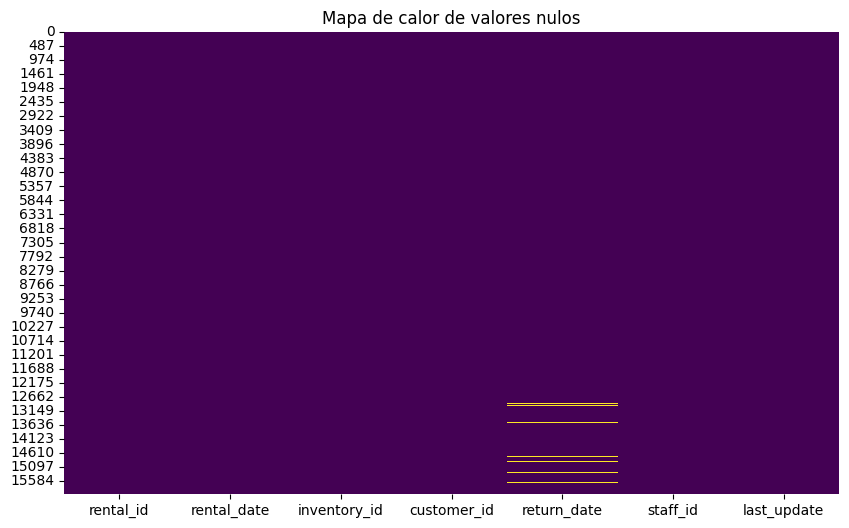

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))
sns.heatmap(df_rental.isnull(), cbar=False, cmap="viridis")
plt.title("Mapa de calor de valores nulos")
plt.show()

### Frecuencias y tendencias

In [ ]:
#Frecuencia de clientes

frecuencia = df_rental.groupby(['customer_id']).size().reset_index(name='frecuencia')

# Ordenamos de mayor a menor por la columna 'frecuencia'
frecuencia = frecuencia.sort_values(by='frecuencia', ascending=False).reset_index(drop=True)

# Mostramos el resultado
print("Frecuencia de clientes")
print(frecuencia)

Frecuencia de clientes
     customer_id  frecuencia
0            148          46
1            526          45
2            144          42
3            236          42
4             75          41
..           ...         ...
594          248          15
595          110          14
596           61          14
597          281          14
598          318          12

[599 rows x 2 columns]


In [ ]:
#Frecuencia películas rentadas

frecuencia = df_rental.groupby(['inventory_id']).size().reset_index(name='frecuencia')

# Ordenamos de mayor a menor por la columna 'frecuencia'
frecuencia = frecuencia.sort_values(by='frecuencia', ascending=False).reset_index(drop=True)

# Mostramos el resultado
print("Frecuencia películas rentadas")
print(frecuencia)

Frecuencia películas rentadas
      inventory_id  frecuencia
0             4581           5
1             1083           5
2             1113           5
3             1111           5
4             2897           5
...            ...         ...
4575          3214           2
4576          2786           1
4577          2662           1
4578          1580           1
4579          3372           1

[4580 rows x 2 columns]


In [ ]:
#Frecuencia películas rentadas por tienda

frecuencia = df_rental.groupby(['staff_id']).size().reset_index(name='frecuencia')

# Ordenamos de mayor a menor por la columna 'frecuencia'
frecuencia = frecuencia.sort_values(by='frecuencia', ascending=False).reset_index(drop=True)

# Mostramos el resultado
print("Frecuencia películas rentadas por tienda")
print(frecuencia)

Frecuencia películas rentadas por tienda
   staff_id  frecuencia
0         1        8040
1         2        8004


In [ ]:
#Frecuencia días que se renta una película

frecuencia = df_film.groupby(['rental_duration']).size().reset_index(name='frecuencia')

# Ordenamos de mayor a menor por la columna 'frecuencia'
frecuencia = frecuencia.sort_values(by='frecuencia', ascending=False).reset_index(drop=True)

# Mostramos el resultado
print("Frecuencia días que se renta una película")
print(frecuencia)

Frecuencia días que se renta una película
   rental_duration  frecuencia
0                6         212
1                4         206
2                3         203
3                5         191
4                7         191


In [ ]:
df_rental['rental_date'] = pd.to_datetime(df_rental['rental_date'], errors='coerce')  # Convertir a tipo datetime
df_rental['return_date'] = pd.to_datetime(df_rental['return_date'], errors='coerce')  # Convertir a tipo datetime
df_rental['Duracion'] = df_rental['return_date'] - df_rental['rental_date']

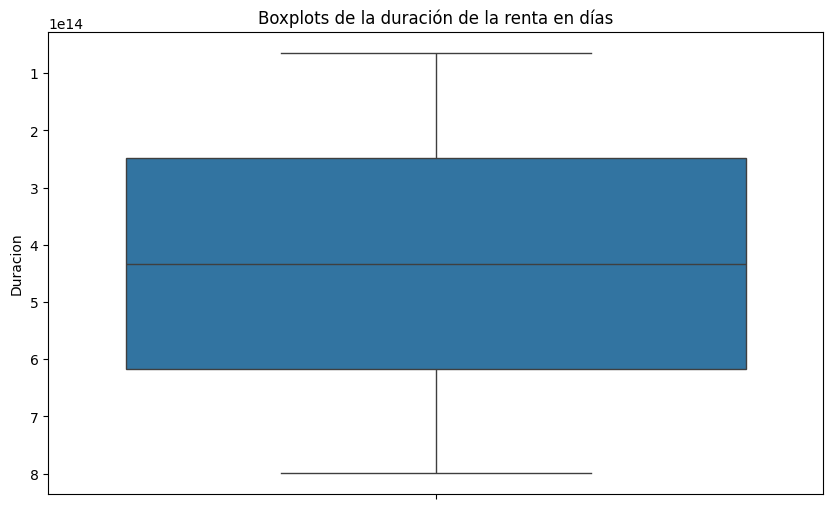

In [ ]:
# Boxplots de la duración de la renta en días

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_rental['Duracion'])
plt.title("Boxplots de la duración de la renta en días")
plt.show()

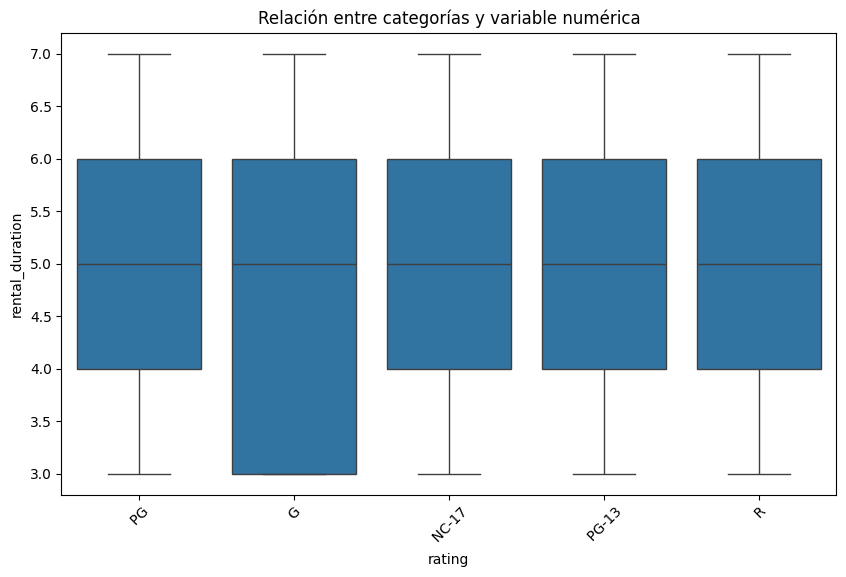

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_film, x="rating", y="rental_duration")
plt.title("Relación entre categorías y variable numérica")
plt.xticks(rotation=45)
plt.show()